In [10]:
import rasterio
import matplotlib.pyplot as plt

In [27]:
from rasterio.plot import show


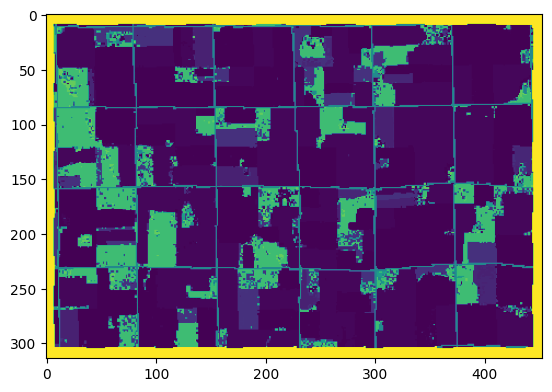

(314, 453)


In [15]:
with rasterio.open('..\\Data\\Remote Sensing\\clipped.tif') as src:
    num_bands = src.count

    for i in range(num_bands):
        band = src.read(i+1)
        plt.imshow(band)
        plt.show()

# shape of the image
print(src.shape)


In [16]:
url_b1 = 'https://modis-pds.s3.amazonaws.com/MCD43A4.006/11/08/2019059/MCD43A4.A2019059.h11v08.006.2019072203257_B01.TIF'


In [22]:
dataset = rasterio.open(url_b1)

In [23]:
band1 = dataset.read(1)

In [24]:
band1.shape

(2400, 2400)

In [20]:
url_b2 = 'https://modis-pds.s3.amazonaws.com/MCD43A4.006/11/08/2019059/MCD43A4.A2019059.h11v08.006.2019072203257_B02.TIF'
dataset = rasterio.open(url_b2)

In [25]:
band2 = dataset.read(1)

In [34]:
ndvi = (band2-band1)/(band2+band1)

C:\Users\DELL\AppData\Local\Temp\ipykernel_70264\3580589560.py:1: RuntimeWarning: invalid value encountered in divide
  ndvi = (band2-band1)/(band2+band1)


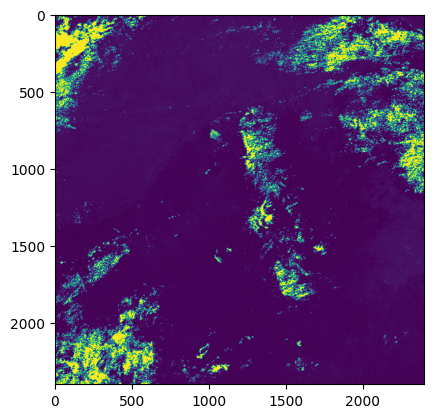

<AxesSubplot: >

In [35]:
show(band1)

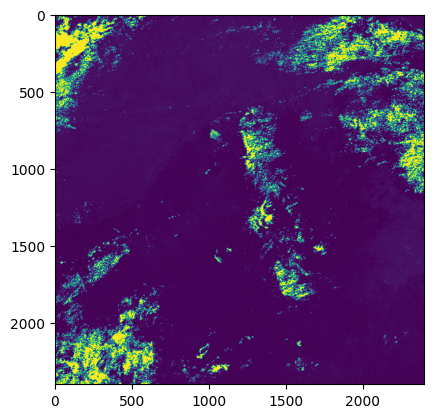

<AxesSubplot: >

In [36]:
show(band2)

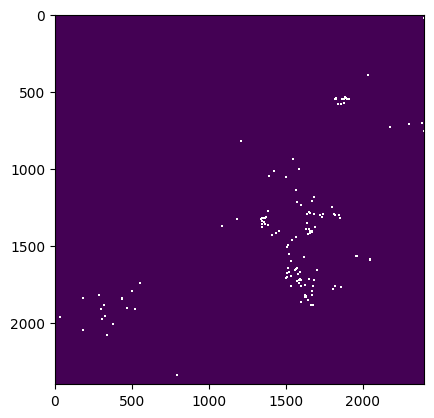

<AxesSubplot: >

In [37]:
show(ndvi)

In [40]:
# concatenate the bands
import numpy as np

bands = np.stack((band1, band2), axis=2)

bands.shape

(2400, 2400, 2)

In [42]:
import sentinelhub



c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [44]:
#First import all needed modules
import sentinelhub
import pandas as pd 
import datetime

#specify tiles, for example two in the eastern part of Austria:
tiles = ["T33UXP","T33UVP"]

#specify start and end date (here we use May 2017)
dateStart = "2017-05-01"
dateEnd = "2017-05-31"

#create date range
dates = pd.date_range(start=dateStart, end=dateEnd)

#loop over tiles
for tile in tiles:
    print("Downloading tile: " + tile)
#loop over dates
    for date in dates:
        print(str(date.date()) + " ...")

        #try if there is a product available for the selected date
        try:
            sentinelhub.download_safe_format(tile=(tile, str(date.date())), entire_product=True)
        except Exception as ex:
            template = "No image for the specified tile / date combination could be found."
            message = template.format(type(ex).__name__)
            print(message)

2017-05-01 ...
No image for the specified tile / date combination could be found.
2017-05-02 ...
No image for the specified tile / date combination could be found.
2017-05-03 ...
No image for the specified tile / date combination could be found.
2017-05-04 ...
No image for the specified tile / date combination could be found.
2017-05-05 ...
No image for the specified tile / date combination could be found.
2017-05-06 ...
No image for the specified tile / date combination could be found.
2017-05-07 ...
No image for the specified tile / date combination could be found.
2017-05-08 ...
No image for the specified tile / date combination could be found.
2017-05-09 ...
No image for the specified tile / date combination could be found.
2017-05-10 ...
No image for the specified tile / date combination could be found.
2017-05-11 ...
No image for the specified tile / date combination could be found.
2017-05-12 ...
No image for the specified tile / date combination could be found.
2017-05-13 ...
N

In [ ]:
from torchgeo.datasets import BigEarthNet

# Specify the root directory where the dataset is located
root_dir = "path/to/dataset/root"

# Instantiate the BigEarthNet dataset
dataset = BigEarthNet(root=root_dir, split="train")

# Access an example from the dataset
sample = dataset[0]

# Access the input image and target label
image = sample["image"]
label = sample["label"]

# Print the shape of the image tensor
print("Image shape:", image.shape)

# Print the label
print("Label:", label)


In [45]:
from lightning.pytorch import Trainer
from torch.utils.data import DataLoader

from torchgeo.datamodules import InriaAerialImageLabelingDataModule
from torchgeo.datasets import CDL, Landsat7, Landsat8, VHR10, stack_samples
from torchgeo.samplers import RandomGeoSampler
from torchgeo.trainers import SemanticSegmentationTask

In [95]:
# landsat7 = Landsat7(root="", bands=["B1", ..., "B7"])
landsat8 = Landsat8(root="..\\Data\\Remote Sensing\\LandSat\\Iowa", bands=["B1", "B2", "B3", "B4","B5", "B6", "B7"])
landsat = landsat8

In [100]:
minx = maxx = miny = maxy = mint = maxt = 0

In [102]:
print(landsat[401385.0, 631215.0, 3394485.0 ,3628515.0 , 1671908400.0, 1671994799.999999])

AttributeError: 'tuple' object has no attribute 'minx'

In [88]:
# access landsat8 image and label
type(landsat)

query = [401385.0, 631215.0, 3394485.0, 3628515.0, 1671908400.0, 1671994799.999999]
keys = ['minx', 'maxx', 'miny', 'maxy', 'mint', 'maxt']
dictionary = dict(zip(keys, query))


sample = landsat.__getitem__(dictionary)
landsat.plot(sample)

RTreeError: Coordinates must not have minimums more than maximums

In [47]:
cdl = CDL(root="...", download=True, checksum=True)
LC08_L2SP_024038_20221225_20230113_02_T1_SR_B1 LC08_L2SP_024038_20221225_20230113_02_T1_B1.TIF

Failed download. Trying https -> http instead. Downloading http://www.nass.usda.gov/Research_and_Science/Cropland/Release/datasets/2022_30m_cdls.zip to ...\2022_30m_cdls.zip


FileNotFoundError: [Errno 2] No such file or directory: '...\\2022_30m_cdls.zip'